# Домашнее задание №1

В данном задании вам предлагаются 3 задачи:
#### 1. Бинарная классификация изображений кошек и собак  (0.4 балла)
Вам потребуется обучить свёрточную нейронную сеть для классификации изображений кошек и собак. Для решения задачи вы зададите архитектуру сети, определите оптимайзер и функцию потерь.  
**Ваша цель:** используя известные вам слои, собрать сеть, дающую $>75\%$ точности классификации на тесте. При обученни нейросети, можете пользоваться вспомогательными функциями *train_model* и *test_model*
#### 2. Обучение классических [ResNet-50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) моделей на наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) (0.6 баллов)
В этой задаче вам необходимо обучить несколько моделей ResNet-50 для решения задачи классификации.  
**Ваша цель:** Обучить ResNet-50 "с нуля" на CIFAR-10, инициировав веса модели случаными значениями. Затем провести сравнение обучения на CIFAR-10 предобученной модели и модели, обучаемой с нуля.  
Есть гипотеза, что предобучение на больших наборах данных, таких как [ImageNet](https://www.image-net.org/), помогает при решение других задач, например классификации на малом наборе данных (см. [Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)). Веса предобученной модели содержат некую информацию о встречающихся в природе изображениях, и эта информация может быть использована при решение задач на малом наборе данных. Сравните точности классификации предобученной ResNet-50 модели с моделью обучаемой с нуля. Обучение моделей проведите на подвыборках обучающей выборки CIFAR-10. Возьмите, например, выборку 1%, 10%, 50%, 80% от размера исходной и нарисуйте зависимость точности моделей на тесте от размера обучающей выборки.
#### 3. Поиск точек схода прямых (Vanishing Points)  (0.6 баллов)
В данной задаче вам предстоит использовать детекторы отрезков на изображении для поиска точки схода прямых ([Постановска задачи](https://arxiv.org/pdf/1608.04267.pdf)). Вам будет предложен набор изображений, на которых присутствует ровно одна точка схождения прямых. С помощью детектора отрезков вы можете найти отрезки на изображении. По имеющимся отрезкам можно вычислить точку их пересечения, которая и будет ответом задачи.   
**Ваша цель:** Найти точки схода прямых с помощью детектора отрезков на представленных изображениях.  
Дополнительные баллы (0.2 балла) будут даваться за качественное сравнение (визуально) нейросетевых детекторов отрезков, например [LSDNet](https://github.com/iitpvisionlab/LSDNet), и классических [Hough Transform](https://en.wikipedia.org/wiki/Hough_transform), [LSD: a Line Segment Detector](http://www.ipol.im/pub/art/2012/gjmr-lsd/article.pdf).  
Критерий нахождения точки схода визуальный: нарисуйте найденную вами точку красным, а точку из разметки зелёным. 
Ваш метод должен найти точки схода прямых на как можно большем числе изображений. Дополнительные бонусные баллы получат решения, которые правильно находят точки схода на большем числе изображений.  
Также вы можете попробовать обучить сеть, предсказывающую точки схода напрямую. Возможный подход для обучения модели будет изложен в описании задачи. 


In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import time
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
from pathlib import Path
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
# используем GPU при наличии
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## Задача 1. Бинарная классификация изображений (0.4 балла)
<img src="https://www.researchgate.net/profile/Atul-Sharma-77/publication/353247632/figure/fig2/AS:1045582240026626@1626297640509/Classification-of-two-classes-dog-and-cat-using-CNN_W640.jpg" alt="drawing" width="700">  


Вам предлагается обучить свёрточную нейронную сеть для решения задачи бинарной классификации изображений кошек и собак.  
Обучить параметры сети вы можете с помощью градиентного спуска, описанного на лекциях.  
Ниже дан вспомогательный код для загрузки изображений и для обучения модели.

In [2]:
# Запускать только если вы работаете в google collab

# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = 'data' # PATH TO THE DATASET

# Number of threads for data loader
NUM_WORKERS = 8

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 96
N_CHANNELS = 3

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 256

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

### Загрузка данных

In [14]:
# !wget -nc https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
# !unzip -n data.zip -d data
# !rm data.zip

### Определение преобразований, применяемых к изображениям

In [15]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

In [16]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset   = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)
test_dataset  = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)

In [17]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

In [18]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

### Функция обучения нейронной сети

In [19]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):
    ''' model: нейросеть для обучения,  
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            opt.step()
            train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in val_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1}/{n_epochs}:\t time {time.time() - start_time:.3f}s,', end="\t")

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100
        
        print(f"training loss (in-iteration): {train_loss_value:.6f},\t  validation accuracy: {val_accuracy_value:.2f} %")

    return train_loss, val_accuracy

### Определение и обучение нейронной сети

### First step

**conv-pool-conv-pool-dense-dense!**

Создайте мини-сверточную нейронную сеть со следующей структурой:
* Входной слой
* 3 классических сверточных блока `convolution->relu->pool`: 
  * свертка 3x3 с 128 фильтрами и функцией активации _ReLU_
  * 2x2 пулинг (или поставьте для предыдущей свертки страйд = 3)
 * Flatten
* 30% Dropout 
* Линейный слой с 256 нейронами и функцией активации _ReLU_
* 30% dropout
* Выходной линейный слой.

Вы также можете добавить [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) слой, который может значительно увеличить скорость сходимости модели

__Convolutional layers__ в торче создаются как любой другой слой, но у него есть особые параметры:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # свёртка`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2 на 2`__

__`...`__


Когда вы закончите создание нейросети, обучите её с оптимайзером __Adam__ с LR = 3e-4 (Константа Карпатого)

Если всё верно, вы должны получить минимум __75%__ точности на валидации.

Количество каналов должно быть в порядке количества class_labels

Вы можете поставить stride=2 для Conv2d слоя чтобы увеличить скорость обучения, но помните про размерности

In [20]:
model_cnn = nn.Sequential()

model_cnn.add_module('conv_1', nn.Conv2d(3, 64, 3, stride=2, padding=1)) # 48 x 48 x 64
# Место для вашего кода: CONV->POOL->CONV-POOL->... as many as you wish
model_cnn.add_module('bn_1', nn.BatchNorm2d(64))
model_cnn.add_module('relu_1', nn.ReLU(inplace=True))
model_cnn.add_module('pool_1', nn.MaxPool2d(2)) # 24 x 24 x 64
model_cnn.add_module('conv_2', nn.Conv2d(64, 64, 3, padding=1)) # 24 x 24 x 64
# model_cnn.add_module('bn_2', nn.BatchNorm2d(64))
model_cnn.add_module('relu_2', nn.ReLU(inplace=True))
model_cnn.add_module('pool_2', nn.MaxPool2d(2)) # 12 x 12 x 64
model_cnn.add_module('conv_3', nn.Conv2d(64, 32, 3, stride=1, padding=1)) # 12 x 12 x 32
model_cnn.add_module('bn_3', nn.BatchNorm2d(32))
model_cnn.add_module('relu_2', nn.ReLU(inplace=True))
model_cnn.add_module('pool_3', nn.MaxPool2d(2)) # 6 x 6 x 32

# End of your code here
# global average pooling
model_cnn.add_module('gap_5', nn.AdaptiveAvgPool2d((2, 2))) # 2 x 2 x 32
# dropout for regularization
model_cnn.add_module('dropout_5', nn.Dropout(0.3))
# "flatten" the data
model_cnn.add_module('flat', Flatten())
# last fully-connected layer, used to create embedding vectors
model_cnn.add_module('fc_6', nn.Linear(128, EMBEDDING_SIZE))
model_cnn.add_module('relu_6', nn.ReLU())
model_cnn.add_module('bn_6', nn.BatchNorm1d(EMBEDDING_SIZE))

model_cnn.add_module('dropout_6', nn.Dropout(0.3))

# logits for NUM_CLASSES=2 classes
model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES))
model_cnn.add_module('fc_preds', nn.Sigmoid())

# move model to computing device
model_cnn = model_cnn.to(device)

In [21]:
train_dataset[0][0].shape

torch.Size([3, 96, 96])

In [22]:
summary(model_cnn, train_dataset[0][0].shape);

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 48, 48]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 48, 48]          128
├─ReLU: 1-3                              [-1, 64, 48, 48]          --
├─MaxPool2d: 1-4                         [-1, 64, 24, 24]          --
├─Conv2d: 1-5                            [-1, 64, 24, 24]          36,928
├─ReLU: 1-6                              [-1, 64, 24, 24]          --
├─MaxPool2d: 1-7                         [-1, 64, 12, 12]          --
├─Conv2d: 1-8                            [-1, 32, 12, 12]          18,464
├─BatchNorm2d: 1-9                       [-1, 32, 12, 12]          64
├─MaxPool2d: 1-10                        [-1, 32, 6, 6]            --
├─AdaptiveAvgPool2d: 1-11                [-1, 32, 2, 2]            --
├─Dropout: 1-12                          [-1, 32, 2, 2]            --
├─Flatten: 1-13                          [-1, 128]                 --
├─L

In [22]:
#Оптимайзер
opt = torch.optim.Adam(model_cnn.parameters(), lr=3e-4)

#Функция потерь (Лосс функция)
loss_fn = torch.nn.CrossEntropyLoss() 
# loss_fn = torch.nn.MSELoss() 

#Число эпох
n_epochs = EPOCH_NUM 

In [19]:
opt.zero_grad()
train_loss, val_accuracy = train_model( model_cnn,
                                        train_loader,
                                        val_loader,
                                        loss_fn,
                                        opt,
                                        n_epochs)

Epoch 1/30:	 time 23.257s,	training loss (in-iteration): 0.639738,	  validation accuracy: 61.87 %
Epoch 2/30:	 time 22.446s,	training loss (in-iteration): 0.587767,	  validation accuracy: 69.47 %
Epoch 3/30:	 time 22.195s,	training loss (in-iteration): 0.551207,	  validation accuracy: 66.09 %
Epoch 4/30:	 time 22.831s,	training loss (in-iteration): 0.526955,	  validation accuracy: 63.72 %
Epoch 5/30:	 time 22.488s,	training loss (in-iteration): 0.510090,	  validation accuracy: 71.66 %
Epoch 6/30:	 time 22.180s,	training loss (in-iteration): 0.506105,	  validation accuracy: 74.45 %
Epoch 7/30:	 time 22.553s,	training loss (in-iteration): 0.492950,	  validation accuracy: 76.60 %
Epoch 8/30:	 time 22.719s,	training loss (in-iteration): 0.488099,	  validation accuracy: 73.64 %
Epoch 9/30:	 time 22.541s,	training loss (in-iteration): 0.477567,	  validation accuracy: 75.17 %
Epoch 10/30:	 time 22.292s,	training loss (in-iteration): 0.480563,	  validation accuracy: 76.64 %
Epoch 11/30:	 time 

In [11]:
def test_model(model, test_loader, subset='test'):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in test_loader:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    test_accuracy = np.mean(test_batch_acc)
    
    print("Results:")
    print(f"  {subset} accuracy:\t\t{test_accuracy * 100:.2f} %")
    if test_accuracy > 0.9:
        print("Amazing!")
    elif test_accuracy > 0.7:
        print("Good!")
    else:
        print("We need more magic! Follow instructons above")
    return test_accuracy

In [21]:
val_accuracy = test_model(model_cnn, val_loader, subset='val')
test_accuracy = test_model(model_cnn, test_loader, subset='test')

Results:
  val accuracy:		82.22 %
Good!
Results:
  test accuracy:		83.91 %
Good!


## Задача 2. Классификация с помощью ResNet50 (0.6 баллов)  
<img src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png" alt="drawing" width="400">  

Вам предлагается обучить популярную свёрточную нейронную сеть [ResNet-50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html)  для решения задачи классификации на наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).  
Выполнение задачи состоит из следующих шагов:
1. Обучение ResNet-50 на CIFAR-10 с нуля и измерение точности классификации на тестовой выборке
2. Дообучение предобученной на [ImageNet](https://www.image-net.org/) ResNet-50 (pretrained=True), сравнение точности с моделью из первого пункта
3. Исследование эффекта Transfer learning. Обучите модели из пунктов 1-2 на подвыборке обучающей выборки CIFAR-10, сохраняя тестовый набор неизменным.
Так как в весах предобученной на ImageNet модели содержится информация о натуральных избражениях, то ей достаточно меньшего обучающего набора (чем для модели, обучаемой с нуля), чтобы получить высокую точность на тесте. Проверте эту гипотезу для размеров обучающей выборки размера 1%, 10%, 50%, 80% от размера исходной. Нарисуйте график, где по оси X отложен размер обучающей выборки, а по оси Y точность на тесте предобученной модели и обученной с нуля. Помогает ли предобучение модели?

### Загрузка данных

In [2]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler

NUM_WORKERS = 8

In [3]:
def get_transform(train):
    if train:
        transform = transforms.Compose(
            [
                transforms.Resize((32, 32)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
                ),
            ]
        )
    else:
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
                ),
            ]
        )
    return transform

DATA_PATH = "cifar_data"
BATCH_SIZE = 128

train_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=True,
    transform=get_transform(train=True),
    download=True,
)
test_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=False,
    transform=get_transform(train=False),
    download=True,
)

train_loader = DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=True,
)

val_loader = DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=True,
)

Files already downloaded and verified
Files already downloaded and verified


### Загрузка модели

Так как разрешение изображений в наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), меньше чем в на наборе данных [ImageNet](https://www.image-net.org/) (целевой набор данных для разработчиков ResNet-50), мы заменим первый свёрточный слой с ядром $(7\times 7)$ и страйдом $2$, на свёрточный слой с ядром размера $(3\times3)$ и страйдом $1$  
Также мы удалим первый maxpolling слой

Определяю свою функцию для получения загрузчика выборки данных с заданной пропорцией  

И свою функцию загрузки модели с заданными параметрами

In [4]:
def get_subset_loader(dataset, fract=0.01, batch_size=BATCH_SIZE):
    '''get a subset of the training data loader with a given fraction of data'''
    if fract > 1.0 or fract <= 0.0:
        raise ValueError("fract must be less than 1.0 and greater than 0.0")
    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        drop_last=True,
        sampler=SubsetRandomSampler(list(range(
            int(np.ceil(fract*len(dataset)/batch_size)*batch_size)))
        ))

def get_resnet50_cifar_model(pretrained=False):
    resnet50 = torchvision.models.resnet50(pretrained=pretrained)#.to(device)

    new_modules = [
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
    ] + list(resnet50.children())[4:-1] + [Flatten(), nn.Sequential(nn.Linear(2048, 10))]
    return torch.nn.Sequential(*new_modules) #.to(device)
    
# train_subset_loader = get_train_subset_loader(train_dset, 0.01)
# for data, targets in train_subset_loader:
#     print(data.shape, targets.shape)

# resnet50_cifar = get_resnet50_cifar_model(pretrained=True)
# summary(resnet50_cifar, (3, 32, 32));

### Обучение и сравнение моделей

Реализую функцию обучения модели и тестирования  
Функции будут возврящать лосс и точность на эпохе

In [5]:
# Место для вашего кода
EPOCHS = 25

def epoch_train(model, device, train_loader, criterion, optimizer, scheduler):
    '''train model for one epoch'''
    pbar = tqdm(train_loader)
    pbar.set_description(f"    Epoch {scheduler.state_dict()['last_epoch']+1}/{EPOCHS} Train")
    
    # train mode
    model.train()
    
    run_loss = 0.0
    run_corrects = 0
    processed_size = 0
    
    for inputs, labels in pbar:
        # learning part
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        
        # metrics part
        run_loss += loss.item() * inputs.size(0)
        run_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
        # progress bar part
        pbar.set_postfix({
            'Loss' : f"{run_loss / processed_size:.4f}",
            'Acc' :  f"{run_corrects.double() / processed_size:.3%}"},
        )
        
    scheduler.step()
    
    epoch_loss = run_loss / processed_size
    epoch_acc = run_corrects.double().item() / processed_size
    return epoch_loss, epoch_acc


# test model on one epoch with test_loader
def test_model(model, device, test_loader, criterion):   
    '''validate model for one epoch'''
    pbar = tqdm(test_loader)
    pbar.set_description(f"                 Val")
    
    # eval mode
    model.eval()
    
    run_loss = 0.0
    run_corrects = 0
    processed_size = 0
    
    for inputs, labels in pbar:
        # inference part
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        # metrics part
        run_loss += loss.item() * inputs.size(0)
        run_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
        # progress bar part
        pbar.set_postfix({
            'Loss' : f"{run_loss / processed_size:.4f}",
            'Acc' :  f"{run_corrects.double() / processed_size:.3%}"},
        )
    
    mean_loss = run_loss / processed_size
    mean_acc = run_corrects.double().item() / processed_size
    return mean_loss, mean_acc


# train model on all epochs    
def train_model(model, device, train_loader, val_loader, 
                criterion, optimizer, scheduler, num_epochs=EPOCHS):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = epoch_train(model, device, train_loader, criterion, optimizer, scheduler)
        val_loss, val_acc = test_model(model, device, val_loader, criterion)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    
    return train_losses, train_accs, val_losses, val_accs

Обучим по циклу модели с нуля и предобученную на ImageNet  
Результаты будут записаны в словарь

In [6]:
import gc

stat_dict = {"Pretrained": {}, "Trained from scratch": {}}

train_fractions = [.01, .1, .5, .8]
val_fractions = [.1, .5, .5, .5]

for train_fraction, val_fraction in zip(train_fractions, val_fractions):    
    train_subset_loader = get_subset_loader(train_dset, train_fraction)
    val_subset_loader = get_subset_loader(test_dset, val_fraction)

    for pretrained in [True, False]:
        model_info = "Pretrained" if pretrained else "Trained from scratch"
        print(f"{train_fraction:.0%} train dataset fraction. {model_info} Resnet50")
        
        resnet50_cifar = get_resnet50_cifar_model(pretrained=pretrained).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(resnet50_cifar.parameters(), lr=0.001, momentum=0.9)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

        train_losses, train_accs, val_losses, val_accs = train_model(
            resnet50_cifar, device, 
            train_subset_loader, val_subset_loader, 
            criterion, optimizer, scheduler, 
            num_epochs=EPOCHS
        )

        print("    Test on full test dataset")
        test_loss, test_acc = test_model(resnet50_cifar, device, val_loader, criterion)
        print(f"    {model_info} Resnet50: Loss = {test_loss:.5f}, Acc = {test_acc:.4%}\n")
        
        train_frac = int(train_fraction * 100)
        stat_dict[model_info][train_frac] = {}
        stat_dict[model_info][train_frac]['train loss'] = train_losses
        stat_dict[model_info][train_frac]['train acc'] = train_accs
        stat_dict[model_info][train_frac]['val loss'] = val_losses
        stat_dict[model_info][train_frac]['val acc'] = val_accs
        stat_dict[model_info][train_frac]['test loss'] = test_loss
        stat_dict[model_info][train_frac]['test acc'] = test_acc 
        
        del resnet50_cifar
        torch.cuda.empty_cache() 
        gc.collect()
    print("\n")

1% train dataset fraction. Pretrained Resnet50


                 Val: 100%|██████████| 8/8 [00:13<00:00,  1.65s/it, Loss=1.8581, Acc=38.477%]


    Test on full test dataset


                 Val: 100%|██████████| 78/78 [00:18<00:00,  4.25it/s, Loss=1.8692, Acc=36.068%]


Pretrained Resnet50: Loss = 1.86921, Acc = 36.0677%

1% train dataset fraction. Trained from scratch Resnet50


                 Val: 100%|██████████| 8/8 [00:12<00:00,  1.61s/it, Loss=2.3142, Acc=16.699%]


    Test on full test dataset


                 Val: 100%|██████████| 78/78 [00:18<00:00,  4.25it/s, Loss=2.2651, Acc=17.698%]


Trained from scratch Resnet50: Loss = 2.26513, Acc = 17.6983%



10% train dataset fraction. Pretrained Resnet50


                 Val: 100%|██████████| 40/40 [00:15<00:00,  2.57it/s, Loss=0.9546, Acc=69.434%]


    Test on full test dataset


                 Val: 100%|██████████| 78/78 [00:15<00:00,  5.13it/s, Loss=0.9428, Acc=69.942%]


Pretrained Resnet50: Loss = 0.94279, Acc = 69.9419%

10% train dataset fraction. Trained from scratch Resnet50


                 Val: 100%|██████████| 40/40 [00:15<00:00,  2.61it/s, Loss=1.7578, Acc=34.766%]


    Test on full test dataset


                 Val: 100%|██████████| 78/78 [00:17<00:00,  4.37it/s, Loss=1.7654, Acc=34.075%]


Trained from scratch Resnet50: Loss = 1.76538, Acc = 34.0745%



50% train dataset fraction. Pretrained Resnet50


                 Val: 100%|██████████| 40/40 [00:11<00:00,  3.37it/s, Loss=0.3310, Acc=90.449%]


    Test on full test dataset


                 Val: 100%|██████████| 78/78 [00:14<00:00,  5.34it/s, Loss=0.3376, Acc=90.475%]


Pretrained Resnet50: Loss = 0.33763, Acc = 90.4748%

50% train dataset fraction. Trained from scratch Resnet50


                 Val: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s, Loss=1.2596, Acc=54.688%]


    Test on full test dataset


                 Val: 100%|██████████| 78/78 [00:18<00:00,  4.27it/s, Loss=1.2704, Acc=53.906%]


Trained from scratch Resnet50: Loss = 1.27038, Acc = 53.9062%



80% train dataset fraction. Pretrained Resnet50


                 Val: 100%|██████████| 40/40 [00:12<00:00,  3.33it/s, Loss=0.2593, Acc=93.086%]


    Test on full test dataset


                 Val: 100%|██████████| 78/78 [00:14<00:00,  5.32it/s, Loss=0.2637, Acc=93.259%]


Pretrained Resnet50: Loss = 0.26368, Acc = 93.2592%

80% train dataset fraction. Trained from scratch Resnet50


                 Val: 100%|██████████| 40/40 [00:12<00:00,  3.24it/s, Loss=1.0794, Acc=61.563%]


    Test on full test dataset


                 Val: 100%|██████████| 78/78 [00:15<00:00,  5.17it/s, Loss=1.0899, Acc=60.777%]

Trained from scratch Resnet50: Loss = 1.08993, Acc = 60.7772%





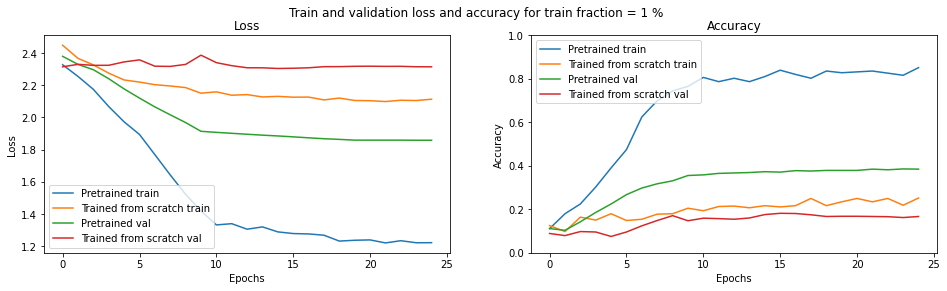

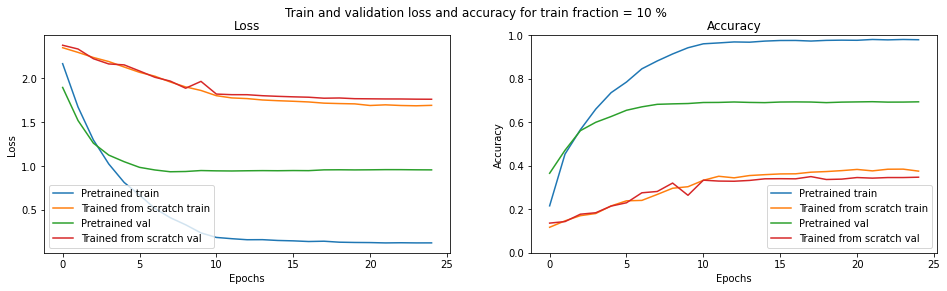

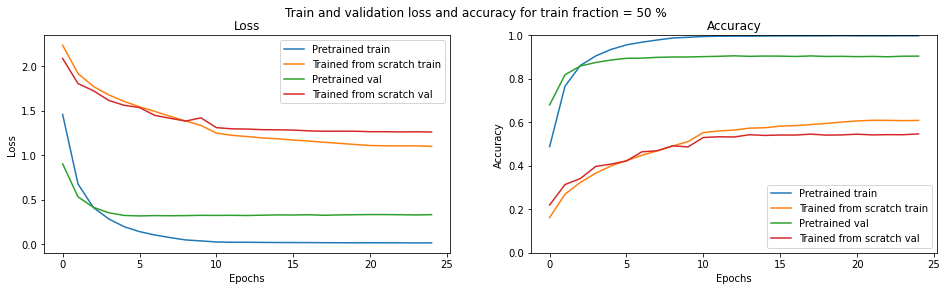

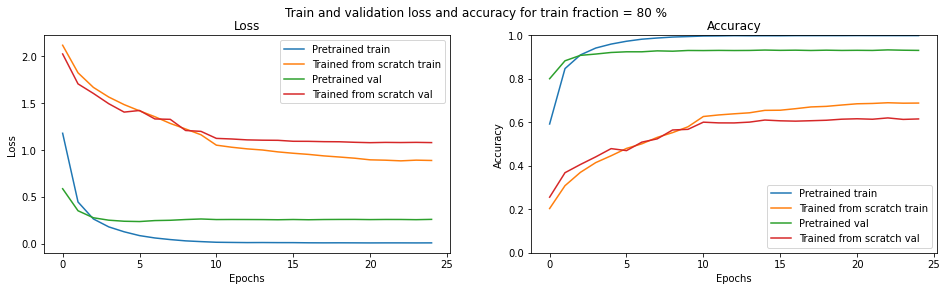

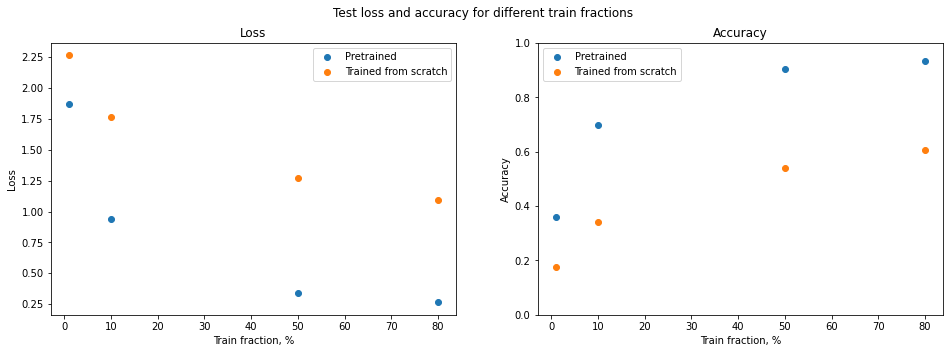

In [7]:
# Plotting the results of the experiment from stat_dict
# Train and validation loss on one plot and train and validation accuracy on another
train_fracs = [1, 10, 50, 80]
losses_pretrained = []
losses_from_scratch = []
accs_pretrained = []
acc_from_scratch = []

# plots for train and validation loss and accuracy
dataset_types = ['train', 'val']
for train_frac in train_fracs:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    fig.suptitle(f"Train and validation loss and accuracy for train fraction = {train_frac} %")
    ax1.set(xlabel='Epochs', ylabel='Loss', title=f"Loss")
    ax2.set(xlabel='Epochs', ylabel='Accuracy', title=f"Accuracy", ylim=(0, 1))
    
    legend = []
    for dtype in dataset_types:
        for model_info in stat_dict:
            ax1.plot(stat_dict[model_info][train_frac][f'{dtype} loss'], label=f"{model_info} train frac = {train_frac}")
            ax2.plot(stat_dict[model_info][train_frac][f'{dtype} acc'], label=f"{model_info} train frac = {train_frac}")
            legend.append(f"{model_info} {dtype}")
    ax1.legend(legend)
    ax2.legend(legend)
    plt.show()
    
    losses_pretrained.append(stat_dict["Pretrained"][train_frac]['test loss'])
    losses_from_scratch.append(stat_dict["Trained from scratch"][train_frac]['test loss'])
    accs_pretrained.append(stat_dict["Pretrained"][train_frac]['test acc'])
    acc_from_scratch.append(stat_dict["Trained from scratch"][train_frac]['test acc'])
    
# plots for test loss and accuracy 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle(f"Test loss and accuracy for different train fractions")
ax1.set(xlabel='Train fraction, %', ylabel='Loss', title=f"Loss")
ax2.set(xlabel='Train fraction, %', ylabel='Accuracy', title=f"Accuracy", ylim=(0, 1))
ax1.plot(train_fracs, losses_pretrained, 'o')
ax1.plot(train_fracs, losses_from_scratch, 'o')
ax2.plot(train_fracs, accs_pretrained, 'o')
ax2.plot(train_fracs, acc_from_scratch, 'o')
ax1.legend(["Pretrained", "Trained from scratch"])
ax2.legend(["Pretrained", "Trained from scratch"])
plt.show()

**Видим, что гипотеза о том, что предобученная модель будет обучаться быстрее, чем модель с нуля, подтвердилась**  
Предобученная модель показывает лучшие результаты на тестовой выборке  

Можно заметить, что при обучении на меньшей части тренировочного датасета у предобученной модели огромная разница между тренировочным и валидационным лоссом. Это говорит о том, что при недостаточном количестве данных модель склонна к переобучению

## Задача 3. Поиск точек схода прямых (Vanishing Points) (0.6 баллов)

<img src="https://zihan-z.github.io/projects/vpdetection/teaser.jpg" alt="drawing" width="800">

Вам предлагается решить задачу поиска точки схода прямых с помощью детектирования отрезков. Также вы можете попробовать нейросетевой способ, где точка схода предсказывается на прямую с помощью нейросети.

#### **Способ решения задачи, основанный на детектировании отрезков:**
В данной задаче вам предстоит использовать детекторы отрезков на изображении для поиска точки схода прямых ([Постановска задачи](https://arxiv.org/pdf/1608.04267.pdf)). Вам будет предложен набор изображений, на которых присутствует ровно одна точка схождения прямых. С помощью детектора отрезков вы можете найти отрезки на изображении. По имеющимся отрезкам можно вычислить точку их пересечения, которая и будет ответом задачи.   
**Ваша цель:** Найти точки схода прямых с помощью детектора отрезков на представленных изображениях.  
Дополнительные баллы (0.2 балла) будут даваться за качественное сравнение (визуально) нейросетевых детекторов отрезков, например [LSDNet](https://github.com/iitpvisionlab/LSDNet), и классических [Hough Transform](https://en.wikipedia.org/wiki/Hough_transform), [LSD: a Line Segment Detector](http://www.ipol.im/pub/art/2012/gjmr-lsd/article.pdf).  
Критерий нахождения точки схода визуальный: нарисуйте найденную вами точку красным, а точку из разметки зелёным. 
Ваш метод должен найти точки схода прямых на как можно большем числе изображений предоставленного ниже набора *vp_images*. Дополнительные бонусные баллы получат решения, которые правильно находят точки схода на большем числе изображений.

In [2]:
# !wget -nc https://dl.dropboxusercontent.com/s/dwy2mo6jd52r5rh/vp_images.zip
# !unzip vp_images.zip

import pandas as pd
import cv2
from PIL import Image
import numpy as np

def view(img):
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    return Image.fromarray(img)

IMGS_PATH = 'vp_images'

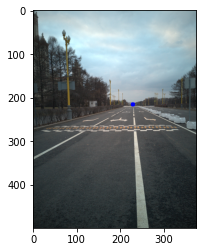

In [3]:
vanish_points_df = pd.read_csv(f'{IMGS_PATH}/vanish_points.csv', sep=';')
img_names = vanish_points_df['file'].to_list()

image_name = '1_SI.png'
image = cv2.imread(f'{IMGS_PATH}/{image_name}')

ind = img_names.index(image_name)
point = (vanish_points_df.iloc[ind].x, vanish_points_df.iloc[ind].y)
image = cv2.circle(image, point, radius=5, color=(255, 0, 0), thickness=-1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

Определим функции для детектирования  

**Детектирование линий**
- Сначала преобразую цветное входное изображение в серое  
- Затем заблюриваю изображение с помощью функции GaussianBlur, чтобы удалить шум в изображении, который приводит к появлению неровных краев, которые не нужны и могут привести к ложным срабатываниям.
- Затем нахожу на зображение грани с помощью функции Canny c пороговыми значениями `canny_thr_lower`, `canny_thr_upper`. 
- Использую вероятностоное преобразование Хафа с порогом `hough_thr`
- После фильтрую найденные линии 
    - по углу, отбрасывая почти вертикальные и почти горизонтальные с указанным порогом `reject_degree_thr`
    - по длине, оставляя самые длинные
- Записываю координаты концов отрезка линии, коэффициенты уравнения прямой, длину линии

**Детектирование точек пересечения**
- Для каждой пары детектированных линий нахожу их точку пересечения,  
- Затем для этой точки определяю расстояние до каждой детектированной линии,  
- Выбираю точку пересечения, расстояние от которой до других минимально

In [4]:
def detect_lines(image, canny_thr_lower=40, canny_thr_upper=250, 
                 reject_degree_thr=2.0, max_lines_cnt=10,
                 gaussian_blur = True, hough_thr=100):
    ''' detect lines in the image using Hough transform
    
    returns list where each line is list:
    ```
        [x1, y1, x2, y2, k, b, l]
    ```
        - `x1, y1, x2, y2` : coordinates of line points   
        - `k, b` : coeffs of line equation y = k*x + b  
        - `l` - line lengh
    
    returns None if no lines detected
    '''
    
    edge = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if gaussian_blur:
        edge = cv2.GaussianBlur(edge, (5, 5), 1)
    edge = cv2.Canny(edge, canny_thr_lower, canny_thr_upper)
    
    lines = cv2.HoughLinesP(edge, 1, np.pi/180, hough_thr, 10, 10)

    if lines is None:
        return None
    
    filtered_lines = []
    for x1, y1, x2, y2 in lines[:,0]: # Iterating over each line
        # find line equation, first slope ( k )
        if x1 != x2:
            k = (y2 - y1) / (x2 - x1)
        else:
            k = 1e8
        b = y2 - k*x2 # b = y - kx 
        # theta ( -90 : +90 )
        theta = np.rad2deg(np.arctan(k))
        # reject almost horizontal or vertical lines
        if reject_degree_thr <= abs(theta) <= (90 - reject_degree_thr):
            # length of the line
            l = np.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )
            filtered_lines.append([x1, y1, x2, y2, k, b, l])
            
        # Taking only the longest lines
        filtered_lines = sorted(filtered_lines, key=lambda x: x[-1], reverse=True)
        filtered_lines = filtered_lines[:max_lines_cnt]
    return filtered_lines

def detect_vanish_point(lines):
    '''detecting coords of single vanishing point
    '''
    vanish_pnt = None # Coordinates of the vanishing point
    min_error = 1e10  # Minimum error found (initially large value)
    for i in range(len(lines)): # Iterating over lines and taking 2 at once
        for j in range(i+1, len(lines)):
            # Reading k and b values
            k1, b1 = lines[i][4:6]
            k2, b2 = lines[j][4:6]
            # If lines are not parallel
            if k1 != k2:
                # intersection point
                x0 = (b1 - b2) / (k2 - k1)
                y0 = k1 * x0 + b1
                err = 0 # initial error of this point
                # Iterating over all lines for measure distance to them
                for m in range(len(lines)):
                    k, b = lines[m][4:6]
                    # perpendicular line
                    k_ = (-1 / k)
                    b_ = y0 - k_ * x0
                    # intersection of line and perpendicular
                    x_ = (b - b_) / (k_ - k)
                    y_ = k_ * x_ + b_
                    # distance between (x0, y0) and (x_, y_)
                    l = np.sqrt((y_ - y0)**2 + (x_ - x0)**2)
                    err += l**2 # Adding to error value
                err = np.sqrt(err) # summary of error for point x0, y0
                # Comparing with minimum error value till now
                # Updating minimum error value and vanishing point coordinates
                if min_error > err:
                    min_error = err
                    vanish_pnt = (int(x0), int(y0))
    return vanish_pnt        

Столкнулся с проблемой, что при изпользовании заблюривания и высоком пороге в преобразовании Хафа не детектируютмя отрезки, поэтому, если они не были найдены, то прогоняю детекцию. ещё раз с заниженным порогом и отключенным заблюриванием.  
Костыль, получается...

In [5]:
pred_pts = []
for i, img_name in enumerate(tqdm(img_names)):
    pt = (vanish_points_df.iloc[i].x, vanish_points_df.iloc[i].y)
    img = cv2.imread(f'{IMGS_PATH}/{img_name}')
    lines = detect_lines(img)
    if not lines or len(lines)==1:
        lines = detect_lines(img, gaussian_blur=False, hough_thr=60)
    if not lines or len(lines)==1:
        pred_pt = (None,None)
    else:
        pred_pt = detect_vanish_point(lines)
    pred_pts.append(pred_pt)

print(f"Обработано {len(pred_pts)} изображений")

100%|██████████| 50/50 [00:00<00:00, 91.77it/s]

Обработано 50 изображений


Для оценки точности детекции возьмём расстояние между предсказанной точкой и известной, затем поделим его на диагональ картинки  

Выведем все изображения с нарисованными на них известными точками (зелёным цветом) и предсказаннми (синим)

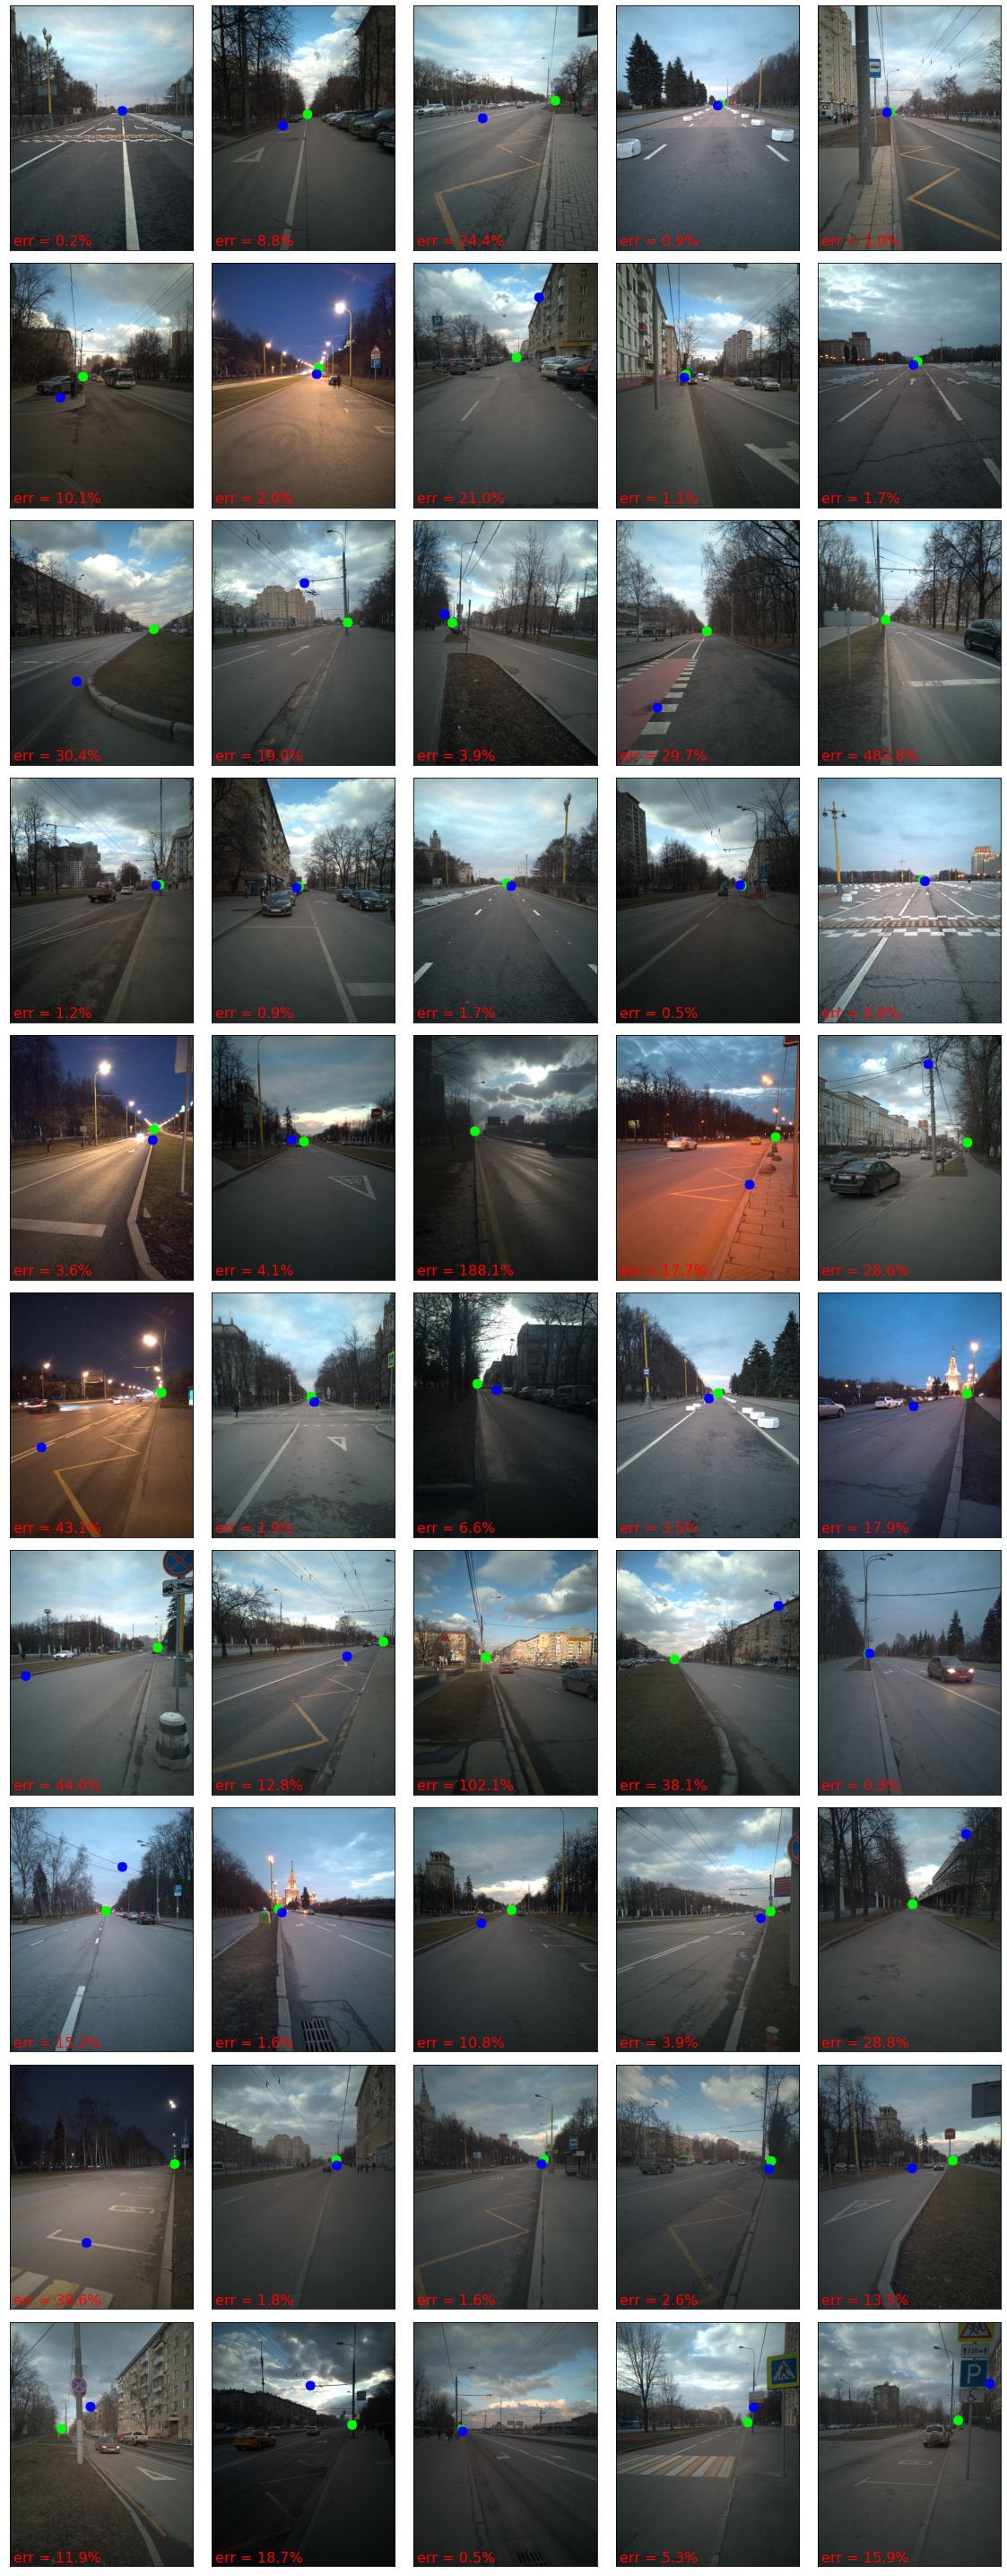

In [6]:
vanish_points_df['pred_x'] = [p[0] for p in pred_pts]
vanish_points_df['pred_y'] = [p[1] for p in pred_pts]
vanish_points_df['err'] = vanish_points_df.apply( lambda r:
    np.sqrt((r['x'] - r['pred_x'])**2 + (r['y'] - r['pred_y'])**2), axis=1
)

errors = []
fig = plt.figure(figsize=(16,40))
for i, img_name in enumerate(img_names):
    # original img
    img = cv2.cvtColor(cv2.imread(f'{IMGS_PATH}/{img_name}'), cv2.COLOR_BGR2RGB)
    # add real point
    pt = (vanish_points_df.iloc[i].x, vanish_points_df.iloc[i].y)
    img = cv2.circle(img, pt, radius=10, color=(0, 255, 0), thickness=-1)
    # add predicted point
    pred_pt = (vanish_points_df.iloc[i].pred_x, vanish_points_df.iloc[i].pred_y)
    img = cv2.circle(img, pred_pt, radius=10, color=(0, 0, 255), thickness=-1)
    
    # calculate error
    h, w, _ = img.shape
    norm_err = vanish_points_df.iloc[i].err / np.sqrt(h**2 + w**2)
    errors.append(norm_err)
    
    # plot
    ax = fig.add_subplot(10, 5, i+1)
    plt.imshow(img)
    plt.text(0.02, 0.02, f"err = {norm_err:.1%}", fontsize = 16, transform=ax.transAxes, color='red')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

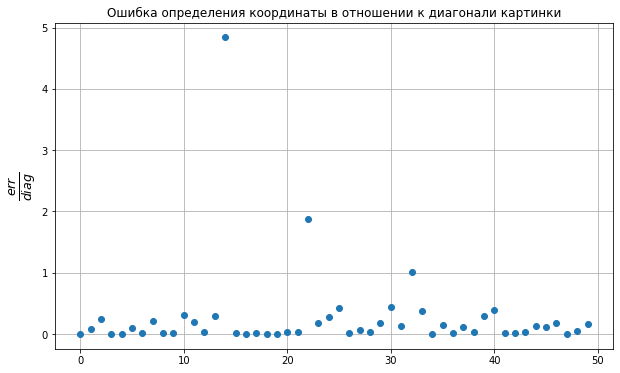

In [18]:
plt.figure(figsize=(10,6))
plt.plot(errors, 'o')
plt.grid()
plt.ylabel("$\\frac{err}{diag}$", fontsize=18)
plt.title('Ошибка определения координаты в отношении к диагонали картинки');

Точность не достаточно хорошая. Ошибка может достигать половины диагонали, в единичных случаях мы вообще не нашли точку в пределах картинки  